In [13]:
import xarray as xr
import xwmb
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [14]:
labels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)"]
kwargs = {"units":r"10$^{9}$ kg/s", "alpha":0.7, "lw":1.5}

In [29]:
import matplotlib.pyplot as plt

def hovmoller(wmt, var, robust=False, units="kg", **kwargs):
    da = wmt[var]
    if robust:
        vmax = np.abs(da).quantile(0.95).compute()
        kwargs["vmin"] = -vmax
        kwargs["vmax"] = vmax

    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    time_idx_bounds = xr.DataArray(np.arange(0, wmt.time_bounds.size), dims=('time_bounds',))
    pc = plt.pcolor(
        time_idx_bounds,
        coord_bounds,
        da.transpose() if da.dims[0] == "time" else da,
        **kwargs
    )

    dtick = da.time.size//12
    date_str = [f"{d.year}-{str(d.month).zfill(2)}-{str(d.day).zfill(2)}" for d in wmt["time_bounds"].values[::dtick]]
    plt.xticks(time_idx_bounds[::dtick], date_str, rotation=90)
    plt.colorbar(label=f"transformation rate [{units}]")
    for coord_bound in coord_bounds:
        plt.axhline(coord_bound, color="k", lw=0.25)
    
    return pc

def stairs(wmt, var, units="kg/s", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"WMT rate [{units}]")
    return l

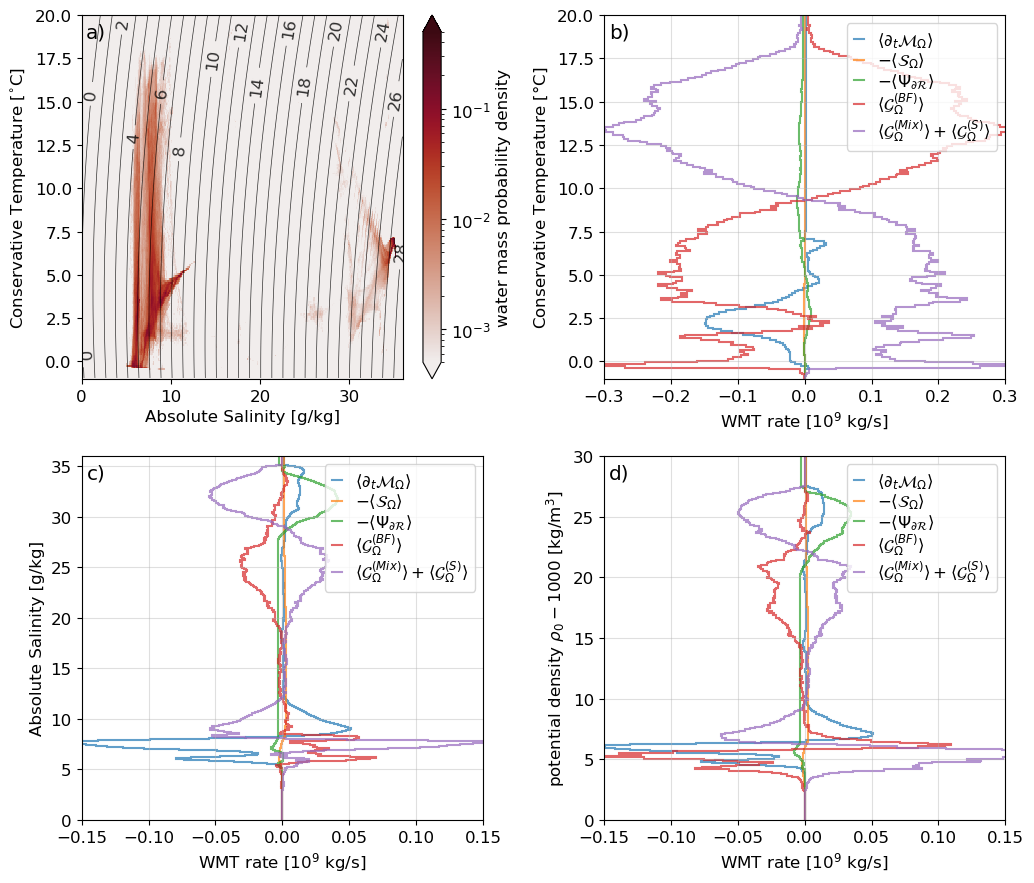

In [30]:
import matplotlib.colors as colors
import cmocean
import gsw
import numpy as np

ylims = {"heat": (-1, 20), "salt": (0, 36), "sigma0": (0, 30)}
ylabels = {"heat": r"Conservative Temperature [$\degree$C]", "salt": "Absolute Salinity [g/kg]", "sigma0": r"potential density $\rho_{0} - 1000$ [kg/m$^{3}$]"}

fig, axes = plt.subplots(2,2,figsize=(10.5,9))

wmt = xr.open_dataset(f"data/baltic_wmb_sigma0_natv_hourly.nc")

i=0
σ0 = gsw.sigma0(wmt.sa_bin, wmt.ct_bin)

ax = axes.flatten()[i]
plt.sca(ax)
pc = wmt.thermo_hist.where(wmt.thermo_hist!=0, 1.e-12).plot(norm=colors.LogNorm(vmin=5.e-4, vmax=5.e-1), x="sa_bin", cmap=cmocean.cm.amp)
pc.colorbar.set_label("water mass probability density")
plt.xlim(ylims["salt"])
plt.ylim(ylims["heat"])

pc = σ0.sel(sa_bin=slice(*ylims["salt"]), ct_bin=slice(*ylims["heat"])).plot.contour(levels=np.arange(0., 30, 1), x="sa_bin", colors="k", linewidths=0.5, alpha=0.8)
ax.clabel(pc, pc.levels[::2], inline=True, fontsize=12)

plt.xlabel("Absolute Salinity [g/kg]")
plt.ylabel("Conservative Temperature [$^{\circ}$C]")
plt.title(f"{labels[i]}", y=0.915, x=0.0125, loc="left")

for i, lam in enumerate(["heat", "salt", "sigma0"], start=1):
    wmt = xr.open_dataset(f"data/baltic_wmb_{lam}_natv_hourly.nc")
    wmt_mean = wmt.mean('time')*1e-9
    wmt_mean["diffusion_both"] = wmt_mean.diffusion + wmt_mean.spurious_numerical_mixing
        
    ax = axes.flatten()[i]
    plt.sca(ax)
    stairs( wmt_mean, 'mass_tendency',             label=r"$\langle \partial_{t} \mathcal{M}_{\Omega} \rangle$",**kwargs)
    stairs(-wmt_mean, 'mass_source',               label=r"$-\langle \mathcal{S}_{\Omega} \rangle$",            **kwargs)
    stairs(-wmt_mean, 'convergent_mass_transport', label=r"$-\langle \Psi_{\partial \mathcal{R}} \rangle$",     **kwargs)
    stairs( wmt_mean, 'boundary_fluxes',           label=r"$\langle \mathcal{G}_{\Omega}^{(BF)} \rangle$",      **kwargs)
    label = r"$\langle \mathcal{G}_{\Omega}^{(Mix)}\rangle + \langle \mathcal{G}_{\Omega}^{(S)} \rangle$"
    stairs( wmt_mean, 'diffusion_both',            label=label,     **kwargs)
    plt.ylabel(ylabels[lam]);
    
    if i>=1:
        plt.legend(handlelength=0.6, labelspacing=0.05, loc="upper right")
        
    plt.grid(True, alpha=0.4)
    plt.ylim(ylims[lam]);
    if lam=="heat":
        plt.xlim(-0.3, 0.3)
    else:
        plt.xlim(-0.15, 0.15)
    plt.title(f"{labels[i]}", y=0.915, x=0.0125, loc="left")

plt.tight_layout()
plt.savefig("figures/offline_budgets_temperature_salinity_density.png", bbox_inches="tight", dpi=250)

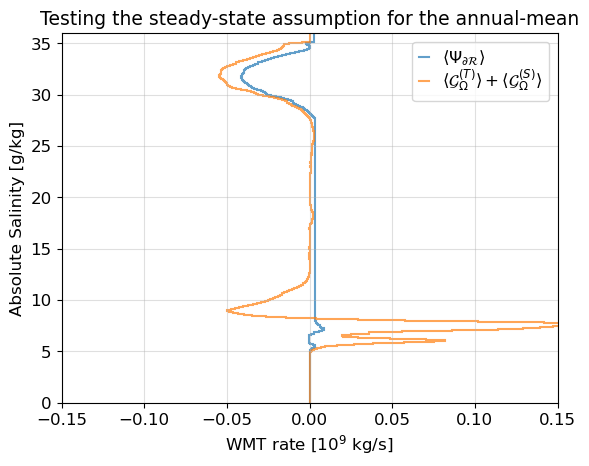

In [31]:
wmt = xr.open_dataset(f"data/baltic_wmb_salt_natv_hourly.nc")
wmt_mean = wmt.mean('time')*1e-9
wmt_mean["all_transformations"] = wmt_mean.diffusion + wmt_mean.spurious_numerical_mixing + wmt_mean.boundary_fluxes
    
stairs( wmt_mean, 'convergent_mass_transport',               label=r"$\langle \Psi_{\partial \mathcal{R}} \rangle$",     **kwargs)
stairs( wmt_mean, 'all_transformations',       label=r"$\langle \mathcal{G}_{\Omega}^{(T)}\rangle + \langle \mathcal{G}_{\Omega}^{(S)} \rangle$",      **kwargs)
plt.ylabel(ylabels["salt"]);
plt.legend(handlelength=0.6, labelspacing=0.05)

plt.grid(True, alpha=0.4)
plt.ylim(ylims["salt"]);
plt.xlim(-0.15, 0.15)
plt.title("Testing the steady-state assumption for the annual-mean", loc="center", fontsize=13.5)
plt.savefig("figures/test_steadystate_budget_assumption.png", bbox_inches="tight", dpi=250)

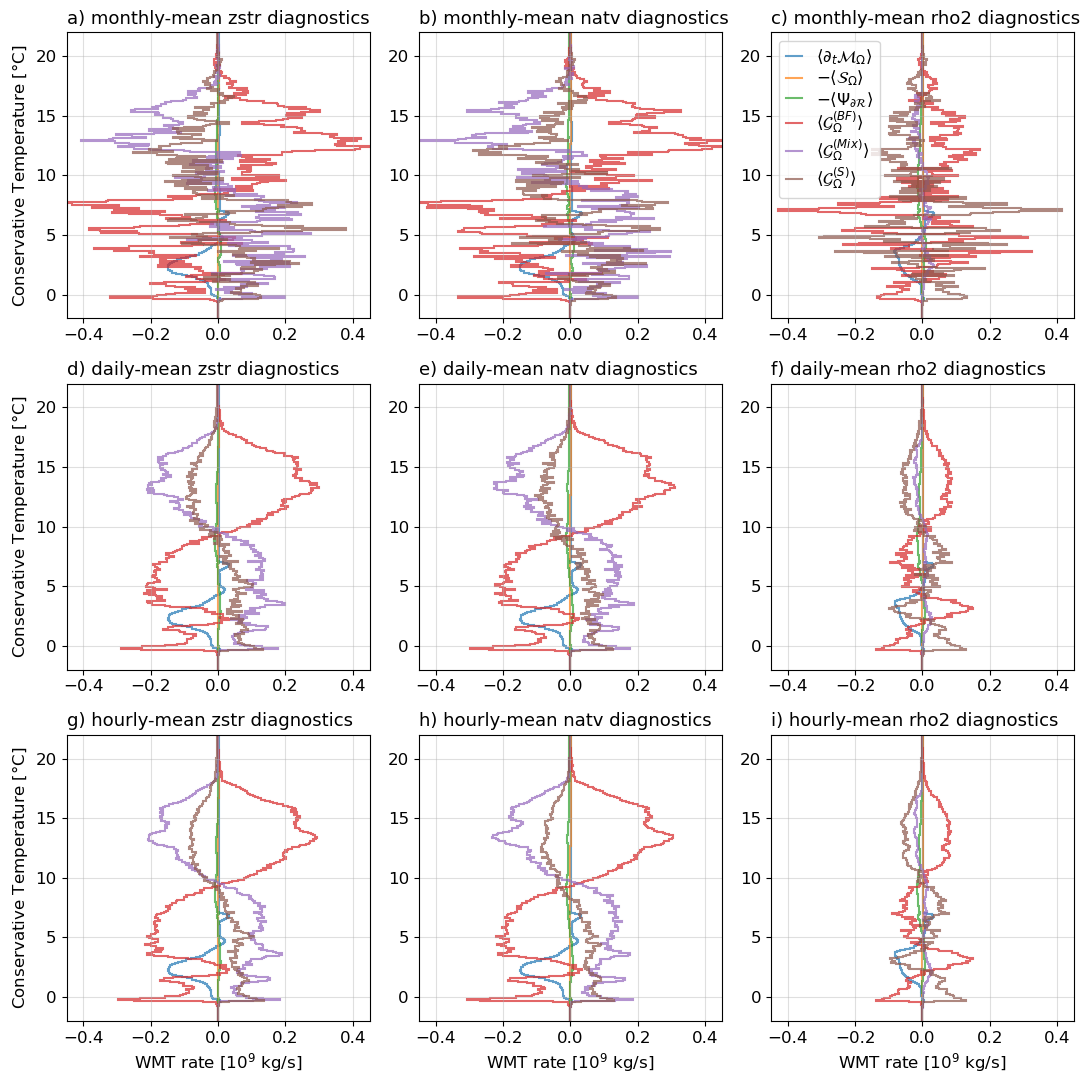

In [36]:
fig, axes = plt.subplots(3,3,figsize=(11,11))
i = 0
for dt in ["monthly", "daily", "hourly"]:
    for gridname in ["zstr", "natv", "rho2"]:
        wmt = xr.open_dataset(f"data/baltic_wmb_heat_{gridname}_{dt}.nc")
        wmt_mean = wmt.mean('time')*1e-9
        
        ax = axes.flatten()[i]
        plt.sca(ax)
        stairs( wmt_mean, 'mass_tendency',             label=r"$\langle \partial_{t} \mathcal{M}_{\Omega} \rangle$",**kwargs)
        stairs(-wmt_mean, 'mass_source',               label=r"$-\langle \mathcal{S}_{\Omega} \rangle$",            **kwargs)
        stairs(-wmt_mean, 'convergent_mass_transport', label=r"$-\langle \Psi_{\partial \mathcal{R}} \rangle$",                   **kwargs)
        stairs( wmt_mean, 'boundary_fluxes',           label=r"$\langle \mathcal{G}_{\Omega}^{(BF)} \rangle$",      **kwargs)
        stairs( wmt_mean, 'diffusion',                 label=r"$\langle \mathcal{G}_{\Omega}^{(Mix)} \rangle$",     **kwargs)
        stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\langle \mathcal{G}_{\Omega}^{(S)} \rangle$", **kwargs)
        plt.ylabel(ylabels["heat"]);

        if i==2:
            plt.legend(loc="upper left", handlelength=1., labelspacing=0.09)
        if gridname != "zstr":
            plt.ylabel("")
        if dt != "hourly":
            plt.xlabel("")
        plt.grid(True, alpha=0.4)
        plt.title(f"{labels[i]} {dt}-mean {gridname} diagnostics", loc="left", fontsize=13)
        plt.title("")
        plt.ylim(-2, 22);
        plt.xlim(-0.45, 0.45)
        i+=1
plt.tight_layout()
plt.savefig("figures/offline_budget_convergence_heat.png", bbox_inches="tight", dpi=250)

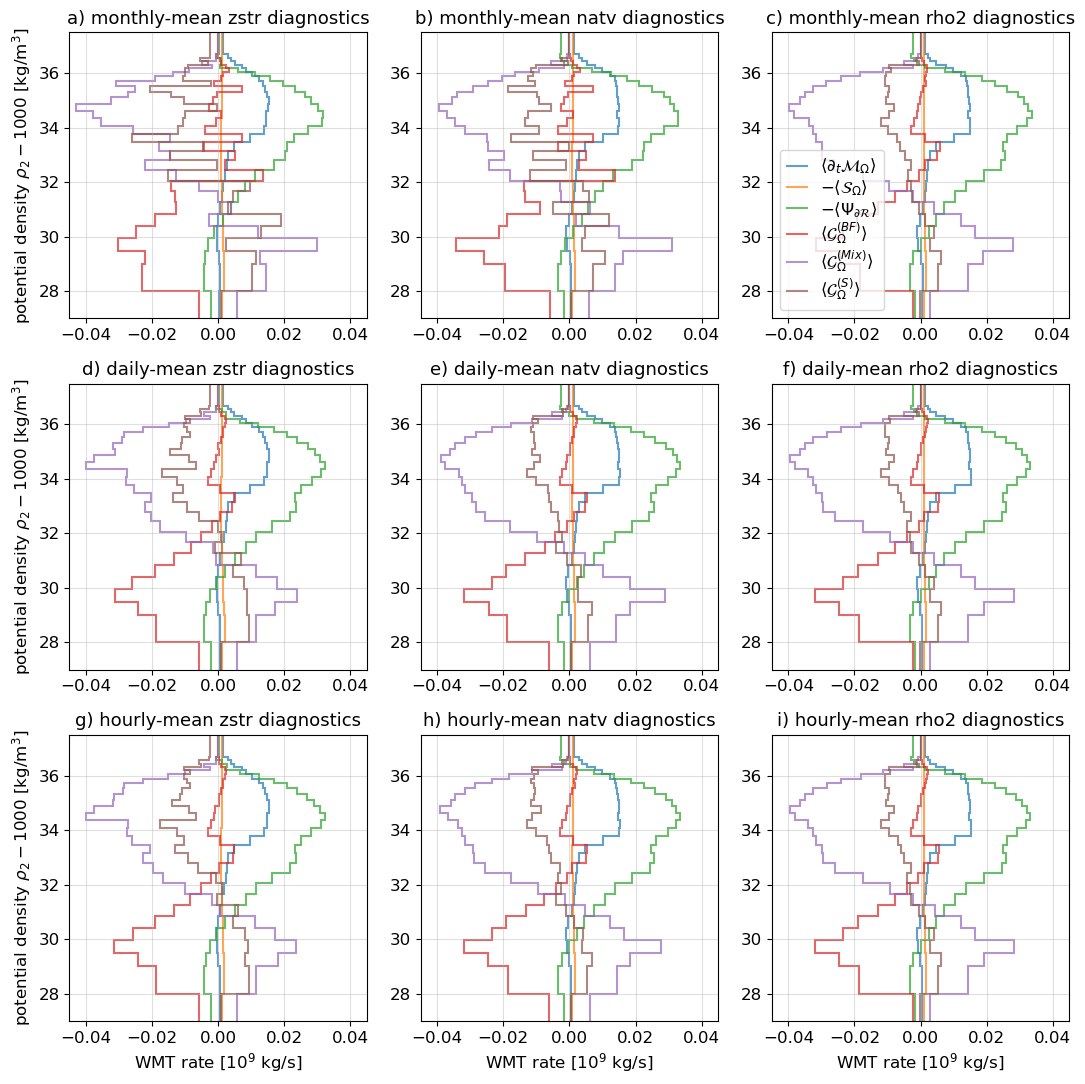

In [37]:
fig, axes = plt.subplots(3,3,figsize=(11,11))
i = 0
for dt in ["monthly", "daily", "hourly"]:
    for gridname in ["zstr", "natv", "rho2"]:
        wmt = xr.open_dataset(f"data/baltic_wmb_sigma2-online-diagbins_{gridname}_{dt}.nc")
        wmt_mean = wmt.mean('time')*1e-9
        
        ax = axes.flatten()[i]
        plt.sca(ax)
        stairs( wmt_mean, 'mass_tendency',             label=r"$\langle \partial_{t} \mathcal{M}_{\Omega}\rangle$",**kwargs)
        stairs(-wmt_mean, 'mass_source',               label=r"$-\langle \mathcal{S}_{\Omega}\rangle$",            **kwargs)
        stairs(-wmt_mean, 'convergent_mass_transport', label=r"$-\langle \Psi_{\partial \mathcal{R}}\rangle$",                   **kwargs)
        stairs( wmt_mean, 'boundary_fluxes',           label=r"$\langle \mathcal{G}_{\Omega}^{(BF)}\rangle$",      **kwargs)
        stairs( wmt_mean, 'diffusion',                 label=r"$\langle \mathcal{G}_{\Omega}^{(Mix)}\rangle$",     **kwargs)
        stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\langle \mathcal{G}_{\Omega}^{(S)} \rangle$", **kwargs)
        plt.ylabel(r"potential density $\rho_{2} - 1000$ [kg/m$^{3}$]");

        if i==2:
            plt.legend(loc="lower left", handlelength=1.2, labelspacing=0.12)
        if gridname != "zstr":
            plt.ylabel("")
        if dt != "hourly":
            plt.xlabel("")
        plt.grid(True, alpha=0.4)
        plt.title(f"{labels[i]} {dt}-mean {gridname} diagnostics", fontsize=13)
        plt.ylim(27, 37.5);
        plt.xlim(-0.045, 0.045)
        i+=1
plt.tight_layout()
plt.savefig("figures/offline_budget_convergence_sigma2-online-diagbins.png", bbox_inches="tight", dpi=250)

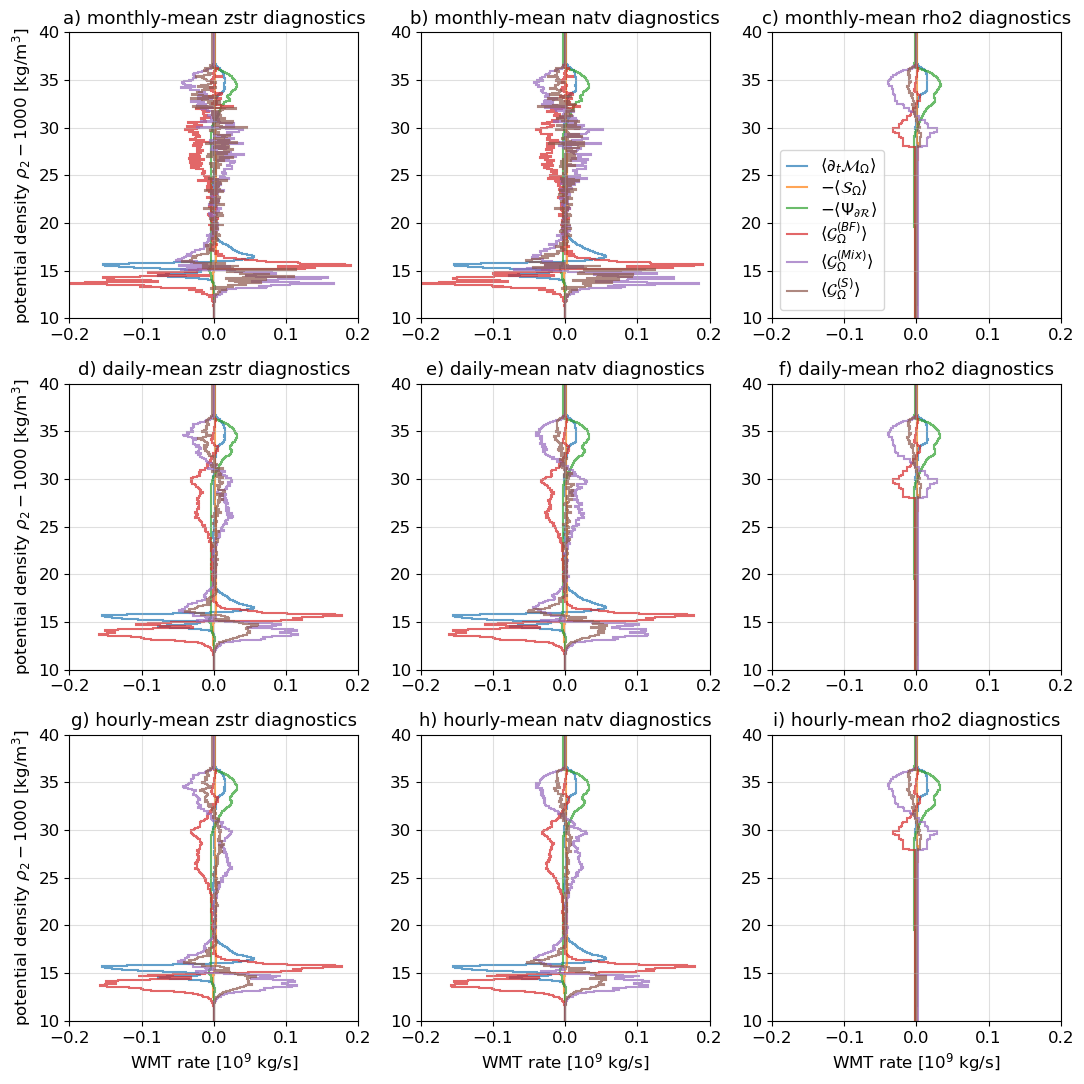

In [38]:
fig, axes = plt.subplots(3,3,figsize=(11,11))
i = 0
for dt in ["monthly", "daily", "hourly"]:
    for gridname in ["zstr", "natv", "rho2"]:
        wmt = xr.open_dataset(f"data/baltic_wmb_sigma2-online_{gridname}_{dt}.nc")
        wmt_mean = wmt.mean('time')*1e-9
        
        ax = axes.flatten()[i]
        plt.sca(ax)
        stairs( wmt_mean, 'mass_tendency',             label=r"$\langle \partial_{t} \mathcal{M}_{\Omega} \rangle$",**kwargs)
        stairs(-wmt_mean, 'mass_source',               label=r"$-\langle \mathcal{S}_{\Omega} \rangle$",            **kwargs)
        stairs(-wmt_mean, 'convergent_mass_transport', label=r"$-\langle \Psi_{\partial \mathcal{R}} \rangle$",                   **kwargs)
        stairs( wmt_mean, 'boundary_fluxes',           label=r"$\langle \mathcal{G}_{\Omega}^{(BF)} \rangle$",      **kwargs)
        stairs( wmt_mean, 'diffusion',                 label=r"$\langle \mathcal{G}_{\Omega}^{(Mix)} \rangle$",     **kwargs)
        stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\langle \mathcal{G}_{\Omega}^{(S)} \rangle$", **kwargs)
        plt.ylabel(r"potential density $\rho_{2} - 1000$ [kg/m$^{3}$]");

        if i==2:
            plt.legend(loc="lower left", handlelength=1.2, labelspacing=0.12)
        if gridname != "zstr":
            plt.ylabel("")
        if dt != "hourly":
            plt.xlabel("")
        plt.grid(True, alpha=0.4)
        plt.title(f"{labels[i]} {dt}-mean {gridname} diagnostics", fontsize=13)
        plt.ylim(10, 40);
        plt.xlim(-0.2, 0.2)
        i+=1
plt.tight_layout()
plt.savefig("figures/offline_budget_convergence_sigma2-online.png", bbox_inches="tight", dpi=250)

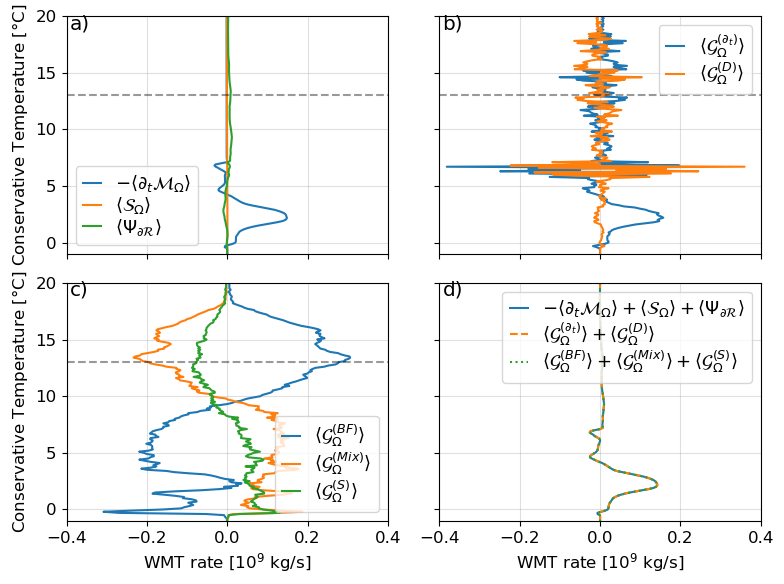

In [44]:
wmt_maps = xr.open_dataset("../paper/data/baltic_wmb_natv_hourly_maps.nc")
thetao0 = wmt_maps.thetao_l_target.values

wmt = xr.open_dataset(f"data/baltic_wmb_heat_natv_hourly.nc")
kw = {"labelspacing":0.06, "handlelength":1., "fontsize":13}

plt.figure(figsize=(8,6))

ax = plt.subplot(2,2,1)
(-wmt['mass_tendency']*1e-9).mean('time').plot(y="thetao_l_target", label=r"$- \langle \partial_{t} \mathcal{M}_{\Omega} \rangle$", color="C0")
(wmt['mass_source']*1e-9).mean('time').plot(y="thetao_l_target", label=r"$\langle \mathcal{S}_{\Omega} \rangle$", color="C1")
(wmt['convergent_mass_transport']*1e-9).mean('time').plot(y="thetao_l_target", label=r"$\langle \Psi_{\partial \mathcal{R}} \rangle$", color="C2")
plt.legend(**kw)
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-0.4, 0.4)
plt.xlabel("");
ax.set_xticklabels([])
plt.ylabel(r"Conservative Temperature [$\degree$C]")
plt.title("a)", loc="left", y=0.91, x=0.01)
plt.axhline(thetao0, color="k", lw=1.5, alpha=0.4, ls="--")

ax = plt.subplot(2,2,2)
(wmt['Eulerian_tendency']*1e-9).mean('time').plot(y="thetao_l_target", label=r"$\langle \mathcal{G}_{\Omega}^{(\partial_{t})} \rangle$", color="C0")
(wmt['diabatic_advection']*1e-9).mean('time').plot(y="thetao_l_target", label=r"$\langle \mathcal{G}_{\Omega}^{(D)} \rangle$", color="C1")
plt.legend(loc="upper right", **kw)
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-0.4, 0.4)
plt.ylabel("")
plt.xlabel("");
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title("b)", loc="left", y=0.91, x=0.01)
plt.axhline(thetao0, color="k", lw=1.5, alpha=0.4, ls="--")

ax = plt.subplot(2,2,3)
(wmt['boundary_fluxes'].mean('time')*1e-9).plot(y="thetao_l_target", label=r"$\langle \mathcal{G}_{\Omega}^{(BF)} \rangle$", color="C0")
(wmt['diffusion']*1e-9).mean('time').plot(y="thetao_l_target", label=r"$\langle \mathcal{G}_{\Omega}^{(Mix)} \rangle$", color="C1")
(wmt['spurious_numerical_mixing']*1e-9).mean('time').plot(y="thetao_l_target", label=r"$\langle \mathcal{G}_{\Omega}^{(S)} \rangle$", color="C2")
plt.legend(loc="lower right", **kw)
plt.grid(True, alpha=0.4)
plt.ylim(-1, 20)
plt.xlim(-0.4, 0.4)
plt.ylabel(r"Conservative Temperature [$\degree$C]")
plt.xlabel(r"WMT rate [$10^{9}$ kg/s]")
plt.title("c)", loc="left", y=0.91, x=0.01)
plt.axhline(thetao0, color="k", lw=1.5, alpha=0.4, ls="--")

ax = plt.subplot(2,2,4)
label = r"$-\langle \partial_{t} \mathcal{M}_{\Omega}\rangle + \langle\mathcal{S}_{\Omega} \rangle + \langle\Psi_{\partial \mathcal{R}} \rangle$"
((-wmt['mass_tendency'] + wmt['mass_source'] + wmt['convergent_mass_transport'])*1e-9).mean('time').plot(y="thetao_l_target", label=label)
label = r"$\langle \mathcal{G}_{\Omega}^{(\partial_{t})}\rangle + \langle \mathcal{G}_{\Omega}^{(D)}\rangle$"
((wmt['Eulerian_tendency'] + wmt['diabatic_advection'])*1e-9).mean('time').plot(y="thetao_l_target", label=label, ls="--")
label= r"$\langle \mathcal{G}_{\Omega}^{(BF)}\rangle + \langle \mathcal{G}_{\Omega}^{(Mix)}\rangle + \langle \mathcal{G}_{\Omega}^{(S)}\rangle$"
((wmt['boundary_fluxes'] + wmt['diffusion'] + wmt['spurious_numerical_mixing'])*1e-9).mean('time').plot(y="thetao_l_target", label=label, ls=":")
plt.grid(True, alpha=0.4)
plt.legend(loc="upper right", **kw)
plt.ylim(-1, 20)
plt.xlim(-0.4, 0.4)
plt.ylabel("")
ax.set_yticklabels([])
plt.title("d)", loc="left", y=0.91, x=0.01)
plt.xlabel(r"WMT rate [$10^{9}$ kg/s]");

plt.tight_layout()
plt.savefig("figures/three_decompositions.png", bbox_inches="tight", dpi=300)